## Need to add the codes below to plots.ipynb

Reproducint plot 8

In [2]:
import jax 
import jax.numpy as jnp
from jax import jit, vmap
from src.models.vsh_model import*
from jax import random
import pandas as pd
import gc
from src.models.configuration import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from src.data.data_utils import*

In [3]:
df = load_qso_dataframe() # load full dataset for 5 param solution

### $G_{mag}$

interested in `phot_g_mean_mag` this will be used to separate the data

In [4]:
G_mag0 = df[df['phot_g_mean_mag']<=18]          # G_mag <= 18
mid0= df[df['phot_g_mean_mag'] > 18]            # middle step
G_mag1 = mid0[mid0['phot_g_mean_mag'] <= 19]    # 18 < G_mag <= 19
mid1 = df[df['phot_g_mean_mag'] > 19] 
G_mag2 = mid1[mid1['phot_g_mean_mag'] <= 20]    # 19 < G_mag <= 20
G_mag3 = df[df['phot_g_mean_mag'] > 20]         # G_mag > 20

Check shape of results (see if it matches the paper results)

In [5]:
print('Shape dataset for G_mag <= 18',G_mag0.shape)
print('Shape dataset for 18 < G_mag <= 19',G_mag1.shape)
print('Shape dataset for 19 < G_mag <= 20',G_mag2.shape)
print('Shape dataset for G_mag > 20',G_mag3.shape)
full_data = df
G_mag_list = [G_mag0, G_mag1, G_mag2, G_mag3, full_data] # collecting everthing into a list

Shape dataset for G_mag <= 18 (29200, 14)
Shape dataset for 18 < G_mag <= 19 (146614, 14)
Shape dataset for 19 < G_mag <= 20 (490161, 14)
Shape dataset for G_mag > 20 (549966, 14)


Perform HMC for $l_{max} = 3$

In [ ]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-.05, .05).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

n_s = 4000 # number of samples
n_warmup = 2000 #  number of warmups 
n_chains = 4 # numbe of chains

In [7]:
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%

posterior_samples_upper = [] # collect posterior samples based on l
step = 0
for G_mag in G_mag_list:

    print(f'G_mag{step}')
    angles, obs, error = config_data(G_mag)
    # Run sampling algoeithm (HMC)
    mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
    mcmc.run(rng_key, angles = angles, obs = obs, error = error, lmax=3)
    ps = mcmc.get_samples()
    posterior_samples_upper.append(ps)
    
    step += 1
    
    # Free memory after each iteration
    del mcmc
    del angles
    del obs
    del error
    gc.collect()
    jax.clear_caches()

G_mag0


/tmp/ipykernel_8347/2245952749.py:12: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
sample: 100%|██████████| 6000/6000 [05:10<00:00, 19.31it/s, 7 steps of size 3.72e-01. acc. prob=0.87] 


G_mag1


sample: 100%|██████████| 6000/6000 [02:20<00:00, 42.58it/s, 7 steps of size 3.34e-01. acc. prob=0.88] 


G_mag2


sample: 100%|██████████| 6000/6000 [04:14<00:00, 23.57it/s, 15 steps of size 3.11e-01. acc. prob=0.90]


G_mag3


sample: 100%|██████████| 6000/6000 [03:44<00:00, 26.70it/s, 7 steps of size 3.87e-01. acc. prob=0.87] 


G_mag4


sample: 100%|██████████| 6000/6000 [09:31<00:00, 10.49it/s, 15 steps of size 3.01e-01. acc. prob=0.88]


plotting results 

In [8]:
import matplotlib.pyplot as plt

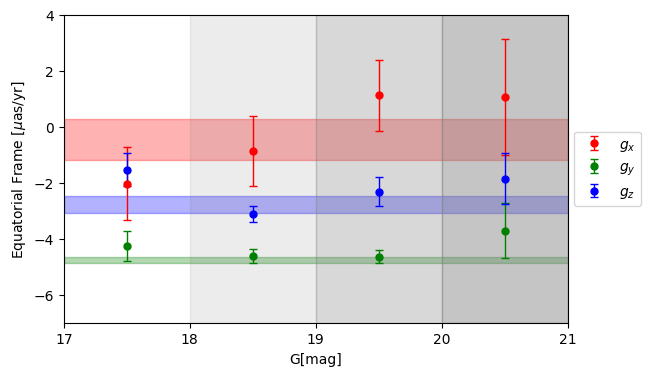

In [ ]:
# For upper panel:
coef_pred = [jnp.mean(ps['theta'], axis=0) for ps in posterior_samples_upper]
std_pred = [jnp.std(ps['theta'], axis=0) for ps in posterior_samples_upper]

G_mag_val = [17.5, 18.5, 19.5, 20.5]
G_mag_label = [17, 18, 19, 20, 21]

C0 = np.sqrt(8*np.pi/3)/1000
C1 = np.sqrt(4*np.pi/3)/1000

# G_mag Vector componets:
gz, gz_error = [coef_pred[z][1]/C0 for z in range(0,4)], [std_pred[z][1]/C0 for z in range(0,4)]
gx, gx_error = [-coef_pred[x][4]/C1 for x in range(0,4)], [std_pred[x][4]/C1 for x in range(0,4)]
gy, gy_error = [coef_pred[y][5]/C1 for y in range(0,4)], [std_pred[y][5]/C1 for y in range(0,4)]

# On full dataset
agz, agz_er = coef_pred[4][1], std_pred[4][1]
agx, agx_er = coef_pred[4][4], std_pred[4][4]
agy, agy_er = coef_pred[4][5], std_pred[4][5]

plt.figure(figsize=(6.5, 4))  
plt.errorbar(G_mag_val, gx, yerr=gx_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_x$', color = 'red')
plt.errorbar(G_mag_val, gy, yerr=gy_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_y$', color = 'green')
plt.errorbar(G_mag_val, gz, yerr=gz_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_z$', color = 'blue')

# Plotting bands
plt.axhspan((agz - agz_er)/C0, (agz + agz_er)/C0, color='blue', alpha=0.3)
plt.axhspan((-agx - agx_er)/C1, (-agx + agx_er)/C1, color='red', alpha=0.3)
plt.axhspan((agy - agy_er)/C1, (agy + agy_er)/C1, color='green', alpha=0.3)

# Plotting gray bands
plt.axvspan(18, 19, alpha = 0.15, color = 'gray')
plt.axvspan(19, 20, alpha = 0.3, color = 'gray')
plt.axvspan(20, 21, alpha = 0.45, color = 'gray')

#plt.title("Equatorial Upper Panel")
plt.xlabel(r'G[mag]')
plt.ylabel(r'Equatorial Frame [$\mu$as/yr]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(G_mag_label, label = G_mag_label)
plt.xlim(17,21)
plt.ylim(-7, 4)
#plt.savefig("plots/main_plots/G_mag_plot.png", dpi=300, bbox_inches='tight')
plt.show()



## $\nu_{eff}$

In [22]:
df

,source_id,ra,dec,pmra,pmdec,parallax,parallax_error,ruwe,phot_g_mean_mag,nu_eff_used_in_astrometry,pmra_error,pmdec_error,pmra_pmdec_corr,astrometric_params_solved
0,3470333738112,45.075505,0.152316,-1.072371,-3.191011,0.366321,0.901633,0.889714,20.571114,1.526179,1.552507,1.226259,0.207769,31
1,5944234902272,44.884761,0.164806,-0.121274,0.725026,-0.395659,1.340139,1.087911,20.704517,1.647388,1.482424,1.402002,0.285303,31
4,10892037246720,45.188575,0.282424,-0.098037,-0.120580,0.001630,0.246332,0.974657,18.787239,1.565118,0.257395,0.223107,0.164329,31
5,15839839588736,45.189480,0.359195,-0.316088,0.318781,-0.333154,0.345819,1.282568,18.888464,1.613716,0.360595,0.326582,0.215161,31
6,19275813399552,44.835496,0.237432,1.062588,0.221073,0.366343,0.603236,0.947865,20.330523,1.584296,0.739487,0.625105,0.258542,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614100,6917241161753591552,315.796881,-0.783980,-0.533850,-0.327224,-0.222744,0.547038,1.091291,19.947210,1.619118,0.638116,0.501641,0.116656,31
1614101,6917243154618290560,315.612393,-0.816968,0.282871,0.062107,-0.583253,0.269573,0.963784,18.960646,1.622210,0.274757,0.220609,0.268015,31
1614109,6917274181462513280,314.319446,-1.446190,-0.375845,-0.410474,-0.026856,0.351059,1.015857,19.559574,1.653227,0.347343,0.247361,0.251226,31
1614114,6917314588515490048,314.608908,-1.021087,0.046539,0.671721,1.268803,1.377943,0.991573,20.776117,1.502613,2.028663,0.947577,-0.118151,31


In [32]:
nu_eff0 = df[df['nu_eff_used_in_astrometry']<=1.55]          # nu_eff <= 1.55
mid0= df[df['nu_eff_used_in_astrometry'] > 1.55]            # middle step
nu_eff1 = mid0[mid0['nu_eff_used_in_astrometry'] <= 1.59]    # 1.55 < nu_mag <= 1.59
mid1 = df[df['nu_eff_used_in_astrometry'] > 1.59] 
nu_eff2 = mid1[mid1['nu_eff_used_in_astrometry'] <= 1.62]    # 1.59 < nu_mag <= 1.62
nu_eff3 = df[df['nu_eff_used_in_astrometry'] > 1.62]         # nu_mag > 1.62

In [33]:
print('Shape dataset for ν_eff <= 1.55',nu_eff0.shape)
print('Shape dataset for 1.55 < ν_mag <= 1.59',nu_eff1.shape)
print('Shape dataset for 1.59 < ν_mag <= 1.62',nu_eff2.shape)
print('Shape dataset for ν_mag > 1.62',nu_eff3.shape)
full_data = df
nu_eff_list = [nu_eff0, nu_eff1, nu_eff2, nu_eff3, full_data] # collecting everthing into a list

Shape dataset for ν_eff <= 1.55 (315233, 14)
Shape dataset for 1.55 < ν_mag <= 1.59 (302515, 14)
Shape dataset for 1.59 < ν_mag <= 1.62 (281541, 14)
Shape dataset for ν_mag > 1.62 (316653, 14)


In [36]:
print('Mean number of datapoint for each sub-set ~', np.round(np.mean([315233, 302515, 281541, 316653])))

Mean number of datapoint for each sub-set ~ 303986.0


In [ ]:
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%

posterior_samples_upper = [] # collect posterior samples based on l
step = 0
for nu_eff in nu_eff_list:

    print(f'nu_eff{step}')
    angles, obs, error = config_data(G_mag)
    # Run sampling algoeithm (HMC)
    mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, progress_bar=True)
    mcmc.run(rng_key, angles = angles, obs = obs, error = error, lmax=3)
    ps = mcmc.get_samples()
    posterior_samples_upper.append(ps)
    
    step += 1
    
    # Free memory after each iteration
    del mcmc
    del angles
    del obs
    del error
    gc.collect()
    jax.clear_caches()

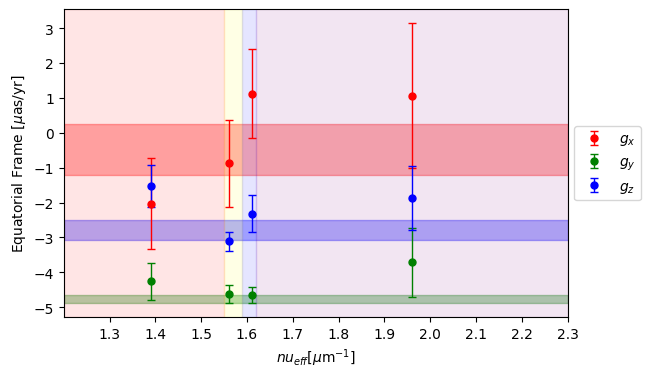

In [37]:
# For upper panel:
coef_pred = [jnp.mean(ps['theta'], axis=0) for ps in posterior_samples_upper]
std_pred = [jnp.std(ps['theta'], axis=0) for ps in posterior_samples_upper]

nu_eff_val = [1.39, 1.56, 1.61, (1.62+2.3)/2]
nu_eff_label = [1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2., 2.1, 2.2, 2.3]

C0 = np.sqrt(8*np.pi/3)/1000
C1 = np.sqrt(4*np.pi/3)/1000

# G_mag Vector componets:
gz, gz_error = [coef_pred[z][1]/C0 for z in range(0,4)], [std_pred[z][1]/C0 for z in range(0,4)]
gx, gx_error = [-coef_pred[x][4]/C1 for x in range(0,4)], [std_pred[x][4]/C1 for x in range(0,4)]
gy, gy_error = [coef_pred[y][5]/C1 for y in range(0,4)], [std_pred[y][5]/C1 for y in range(0,4)]

# On full dataset
agz, agz_er = coef_pred[4][1], std_pred[4][1]
agx, agx_er = coef_pred[4][4], std_pred[4][4]
agy, agy_er = coef_pred[4][5], std_pred[4][5]

plt.figure(figsize=(6.5, 4))  
plt.errorbar(nu_eff_val, gx, yerr=gx_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_x$', color = 'red')
plt.errorbar(nu_eff_val, gy, yerr=gy_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_y$', color = 'green')
plt.errorbar(nu_eff_val, gz, yerr=gz_error, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$g_z$', color = 'blue')

# Plotting bands
plt.axhspan((agz - agz_er)/C0, (agz + agz_er)/C0, color='blue', alpha=0.3)
plt.axhspan((-agx - agx_er)/C1, (-agx + agx_er)/C1, color='red', alpha=0.3)
plt.axhspan((agy - agy_er)/C1, (agy + agy_er)/C1, color='green', alpha=0.3)

# Plotting gray bands
plt.axvspan(1.2, 1.55, alpha = 0.1, color = 'red')
plt.axvspan(1.55, 1.59, alpha = 0.1, color = 'yellow')
plt.axvspan(1.59, 1.62, alpha = 0.1, color = 'blue')
plt.axvspan(1.62, 2.3, alpha = 0.1, color = 'purple')

#plt.title("Equatorial Upper Panel")
plt.xlabel(r'$nu_{eff}$[$\mu \text{m}^{-1}$]')
plt.ylabel(r'Equatorial Frame [$\mu$as/yr]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(nu_eff_label, label = nu_eff_label)
plt.xlim(1.2, 2.3)
#plt.ylim(-7, 4)
#plt.savefig("plots/main_plots/G_mag_plot.png", dpi=300, bbox_inches='tight')
plt.show()

